# EIT-CEM Numerical Tests

In [1]:
#Fixing paths
import sys
import time
sys.path.append('../../FEIT_codes') # Add the parent directory to the path list

#Importing modules
from FEIT_onefile import *
import pandas as pd
import seaborn as sns
sns.set_context("talk")


#Experiment name
exp_name="CEM"

## Mesh

In [2]:
"Basic Definitions"
r=1            #Circle radius
L=8            #Number of Electrodes
per_cober=0.5  #Percentage of area covered by electrodes
rotate=0       #Rotation

#Return object with angular position of each electrode
ele_pos=electrodes_position(L, per_cober, rotate)

N: 1681, M: 480, K:2880


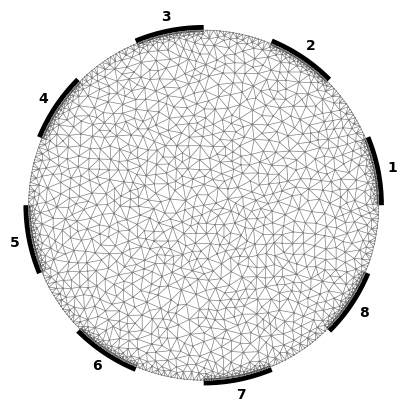

In [3]:
refine_n=20 #Refinement mesh
n_in=40     #Vertex on elec.
n_out=20    #Vertex on gaps (Sometimes it is important.)

#Generating Mesh
mesh=MyMesh(r=r, n=refine_n, n_in=n_in, n_out=n_out, electrodes_obj=ele_pos)

#Plotting and saving mesh
plot_electrodes(mesh, linewidth_mesh=0.5, linewidth_elec=5, figsize=(5,5), fontsize=10)
plt.savefig("figures/{}/teste2_triang.png".format(exp_name), bbox_inches='tight', transparent=True)

#Mesh config
bmesh=BoundaryMesh(mesh, 'exterior', order=True)
print("N: {}, M: {}, K:{}".format(mesh.num_vertices(), bmesh.num_vertices(), mesh.num_cells()))

## Defining $\gamma$

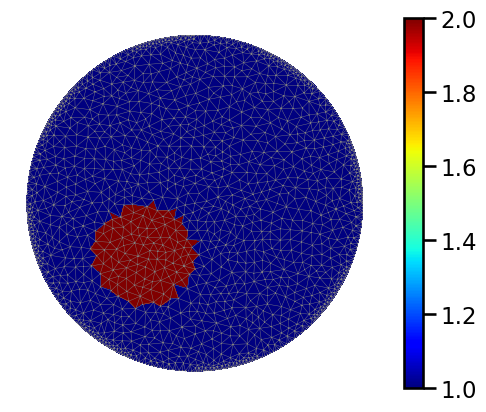

In [4]:
#Defining the function gamma in Descontinuous Galerkin
Q = FunctionSpace(mesh, "DG", 0) #Define Function space with basis Descontinuous Galerkin
ValuesCells0=GammaCircle(mesh,2,1.0,0.3, -0.3, -0.3); #mesh, cond_in, cond_out, radius, certerx, cerntery
gamma = Function(Q)
gamma.vector()[:]=ValuesCells0

#Plotting gamma
"Plot"
plot_figure(gamma, name="", map="jet");
plot(mesh, linewidth=0.3)
plt.xticks([])
plt.yticks([])
plt.box(False)
plt.savefig("figures/{}/teste2_cond.png".format(exp_name), bbox_inches='tight', transparent=True)

## Forward Problem

In [5]:
#Defining impedances, experiments and currents
z=np.ones(L)*2.5E-5     #Impedance of each electrode
l=L-1                   #Numero of experiments
I_all=current_method( L , l, method=2)  #Current

print(I_all)

[[ 1. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  1. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  1. -1.]]


In [6]:
#Defining ForwardObject Problem 
ForwardObject=ForwardProblem(mesh, z)

#Solving Forward Problem
VD=FiniteElement('CG',mesh.ufl_cell(),1) #Solution Space: Continous Galerkin
list_u, list_U0_m = ForwardObject.solve_forward(VD, I_all, gamma)
list_U0 = np.array(list_U0_m).flatten()


### Plotting potentials on $\Omega$

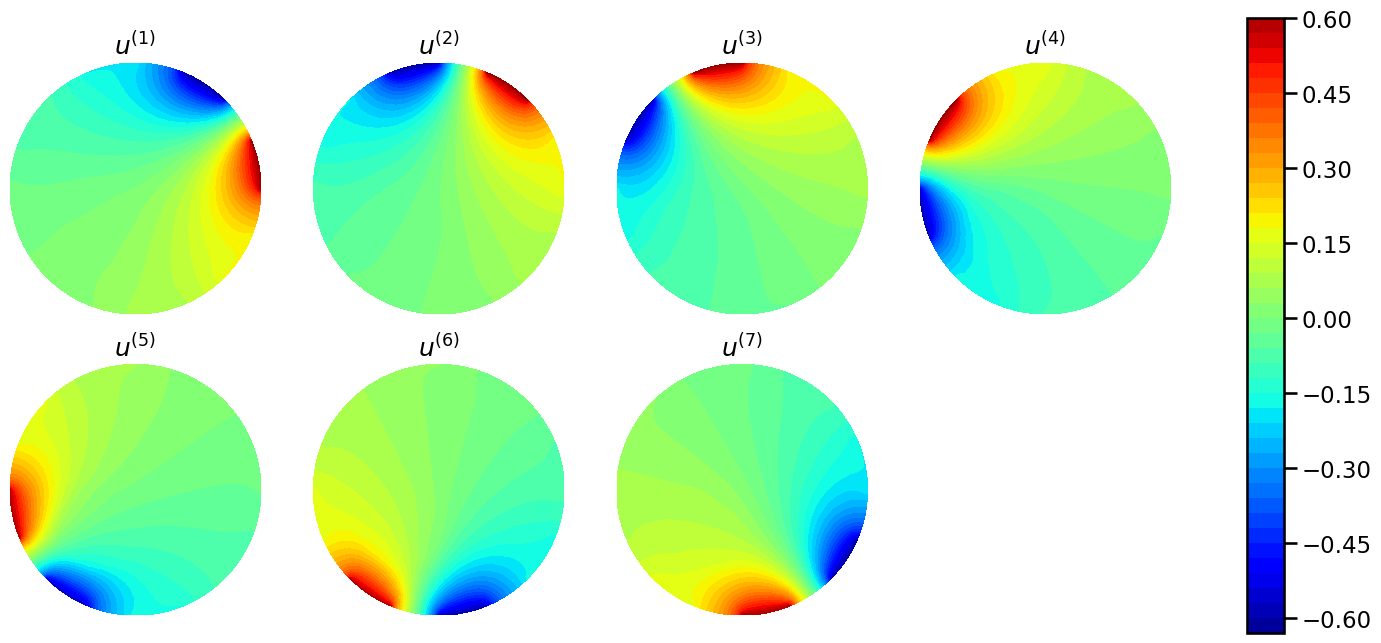

In [7]:
fig = plt.figure(figsize=(15,15))
for i,u in enumerate(list_u,1):
    plt.subplot(4,4,i)
    p = plot(u, title=f'$u^{{({i})}}$')
    p.set_cmap("jet")
    p.set_clim(-0.65,0.65)
    plt.xticks([])
    plt.yticks([])
    plt.box(False)
cbar_ax = fig.add_axes([0.95,0.5,0.025,0.41])
fig.colorbar(p, cax=cbar_ax, orientation="vertical")
plt.savefig("figures/{}/teste2_u.png".format(exp_name), bbox_inches='tight', transparent=True)

### Visualizing potential matrix $U$

In [8]:
#Print matrix with precision of 5 decimals
np.set_printoptions(precision=5, suppress=True)
print(np.matrix(list_U0_m))

[[ 0.60876 -0.61029 -0.1826  -0.07688 -0.01846  0.02149  0.07609  0.18189]
 [ 0.18236  0.61004 -0.60764 -0.17982 -0.07462 -0.02551  0.01791  0.07728]
 [ 0.07669  0.18241  0.61022 -0.60406 -0.17196 -0.07899 -0.0312   0.01689]
 [ 0.01315  0.07157  0.17677  0.60887 -0.58871 -0.16425 -0.08374 -0.03367]
 [-0.02475  0.01521  0.06432  0.15729  0.58174 -0.56846 -0.15454 -0.07081]
 [-0.06626 -0.01165  0.03176  0.07955  0.16006  0.57398 -0.59983 -0.16762]
 [-0.18058 -0.07479 -0.01541  0.03268  0.08274  0.16647  0.59868 -0.60978]]


In [9]:
#Generating matrix to Latex
df=pd.DataFrame(list_U0_m)
print(df.to_latex(index=False,
                  header=False,
                  float_format="{:.5f}".format,
))  

\begin{tabular}{rrrrrrrr}
\toprule
 0.60876 & -0.61029 & -0.18260 & -0.07688 & -0.01846 &  0.02149 &  0.07609 &  0.18189 \\
 0.18236 &  0.61004 & -0.60764 & -0.17982 & -0.07462 & -0.02551 &  0.01791 &  0.07728 \\
 0.07669 &  0.18241 &  0.61022 & -0.60406 & -0.17196 & -0.07899 & -0.03120 &  0.01689 \\
 0.01315 &  0.07157 &  0.17677 &  0.60887 & -0.58871 & -0.16425 & -0.08374 & -0.03367 \\
-0.02475 &  0.01521 &  0.06432 &  0.15729 &  0.58174 & -0.56846 & -0.15454 & -0.07081 \\
-0.06626 & -0.01165 &  0.03176 &  0.07955 &  0.16006 &  0.57398 & -0.59983 & -0.16762 \\
-0.18058 & -0.07479 & -0.01541 &  0.03268 &  0.08274 &  0.16647 &  0.59868 & -0.60978 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_282/2941746471.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False,


### Potentials $U$ as a vector

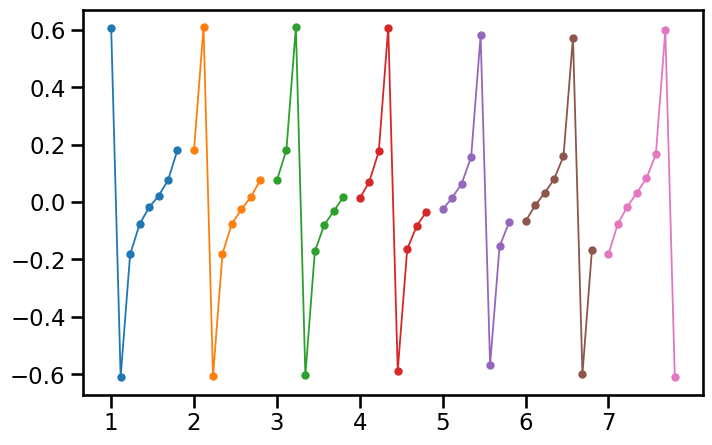

In [10]:
fig, ax = plt.subplots(figsize=(8,5))

for i, U_vec in enumerate(list_U0_m):
    x=np.linspace(1,1.8,L)+i
    ax.plot(x,U_vec, linewidth=1.3, marker='.', markersize=10);

plt.xticks(np.arange(1,l+1,1))
plt.savefig("figures/{}/teste2_U.png".format(exp_name), bbox_inches='tight', transparent=True)

## Numerical Tests

### Test 1: $\operatorname{div}(\gamma \nabla u)\approx 0 $

Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.


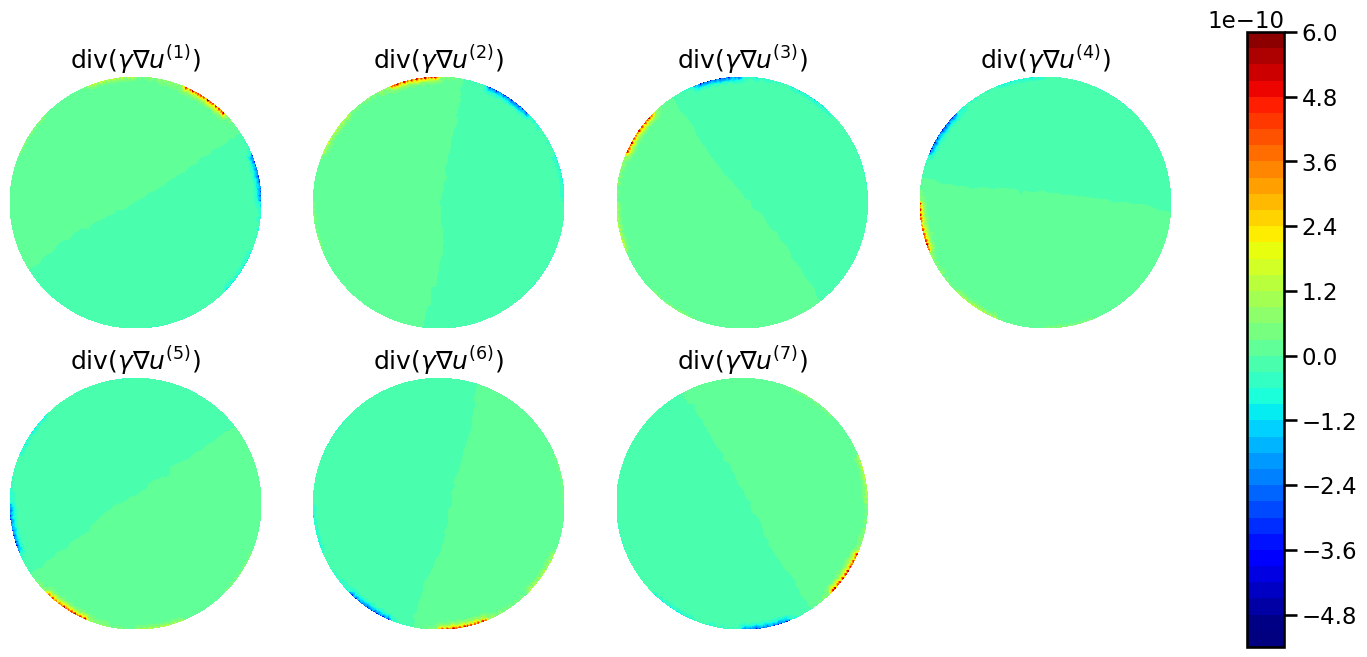

In [11]:
fig = plt.figure(figsize=(15,15)) #Preparing figure

for i,u in enumerate(list_u,1): #Loop
    #Interpolating u in a degree 2 basis
    u=project(u, FunctionSpace(mesh, "CG", 2))
    div_gamma_grad_u = div(gamma*grad(u)) #Calc. the div(gamma*grad(u))
    
    #Plotting
    plt.subplot(4,4,i)
    p = plot(div_gamma_grad_u, title=f'div$(\\gamma\\nabla u^{{({i})}})$')
    p.set_cmap("jet")
    p.set_clim(-5E-10,6E-10)
    plt.xticks([])
    plt.yticks([])
    plt.box(False)
    plt.axis('off')

cbar_ax = fig.add_axes([0.95,0.5,0.025,0.41])
fig.colorbar(p, cax=cbar_ax, orientation="vertical")
plt.savefig("figures/{}/teste2_fluxos.png".format(exp_name), bbox_inches='tight', transparent=True)
plt.show()

### Teste 2:  $\int_{E_j} \gamma \frac{\partial u}{\partial \eta} \approx I_j, \quad \forall j \in \{1 \ldots, L\}$

In [12]:
#Inputs
n = FacetNormal(mesh) #Normal vector
de = ForwardObject.de #Electrodes element area

#Loop
res_I_m = np.zeros((l,L)) #Auxiliar matrix
for j, u in enumerate(list_u):
    for i in range(L):
        integral_i=assemble(inner(n,gamma*grad(u))*de(i+1))
        res_I_m[j,i]=I_all[j,i]-integral_i
print(res_I_m)

[[ 0.20449 -0.19779  0.00703  0.00127  0.00086 -0.0004  -0.00063 -0.00537]
 [-0.00159  0.20699 -0.22061  0.00626  0.00193  0.00016  0.00001 -0.00092]
 [ 0.00067 -0.00824  0.21696 -0.22453  0.00736  0.00119  0.00038 -0.00015]
 [ 0.00092 -0.00227 -0.00505  0.22377 -0.20854  0.00691  0.00117  0.00024]
 [ 0.00115 -0.0009  -0.00073 -0.00629  0.20287 -0.21612  0.00677  0.00112]
 [ 0.00283 -0.00046  0.00015 -0.00082 -0.00459  0.21655 -0.20946  0.00673]
 [ 0.00993 -0.00008  0.00063 -0.00004 -0.00028 -0.00682  0.20613 -0.21993]]


In [13]:
#Generating matrix to Latex
df=pd.DataFrame(res_I_m)
print(df.to_latex(index=False,
                  header=False,
                  float_format="{:.5f}".format,
))  

\begin{tabular}{rrrrrrrr}
\toprule
 0.20449 & -0.19779 &  0.00703 &  0.00127 &  0.00086 & -0.00040 & -0.00063 & -0.00537 \\
-0.00159 &  0.20699 & -0.22061 &  0.00626 &  0.00193 &  0.00016 &  0.00001 & -0.00092 \\
 0.00067 & -0.00824 &  0.21696 & -0.22453 &  0.00736 &  0.00119 &  0.00038 & -0.00015 \\
 0.00092 & -0.00227 & -0.00505 &  0.22377 & -0.20854 &  0.00691 &  0.00117 &  0.00024 \\
 0.00115 & -0.00090 & -0.00073 & -0.00629 &  0.20287 & -0.21612 &  0.00677 &  0.00112 \\
 0.00283 & -0.00046 &  0.00015 & -0.00082 & -0.00459 &  0.21655 & -0.20946 &  0.00673 \\
 0.00993 & -0.00008 &  0.00063 & -0.00004 & -0.00028 & -0.00682 &  0.20613 & -0.21993 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_282/1425707784.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False,


### Plotting $I^{(i)}-I^{\star (i)}$

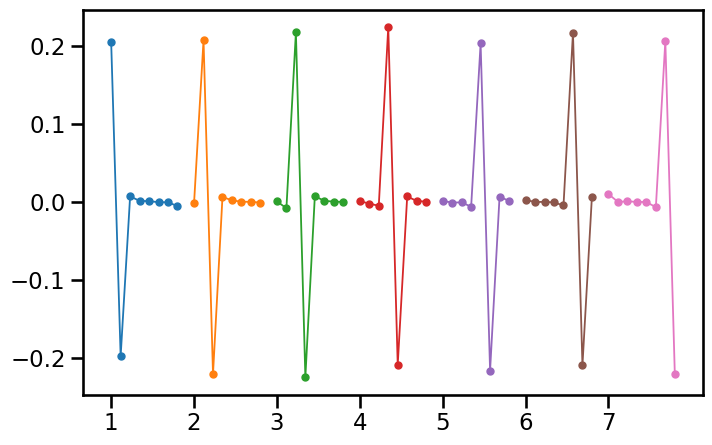

In [40]:
fig, ax = plt.subplots(figsize=(8,5))

for i, I_vec in enumerate(res_I_m):
    x=np.linspace(1,1.8,L)+i
    ax.plot(x,I_vec, linewidth=1.3, marker='.', markersize=10);

plt.xticks(np.arange(1,l+1,1))
plt.savefig("figures/{}/teste2_I_star.png".format(exp_name), bbox_inches='tight', transparent=True)

### Teste 3: $\left(\gamma\frac{\partial u}{\partial \eta} \right) \circ \phi$ on $\partial\Omega$

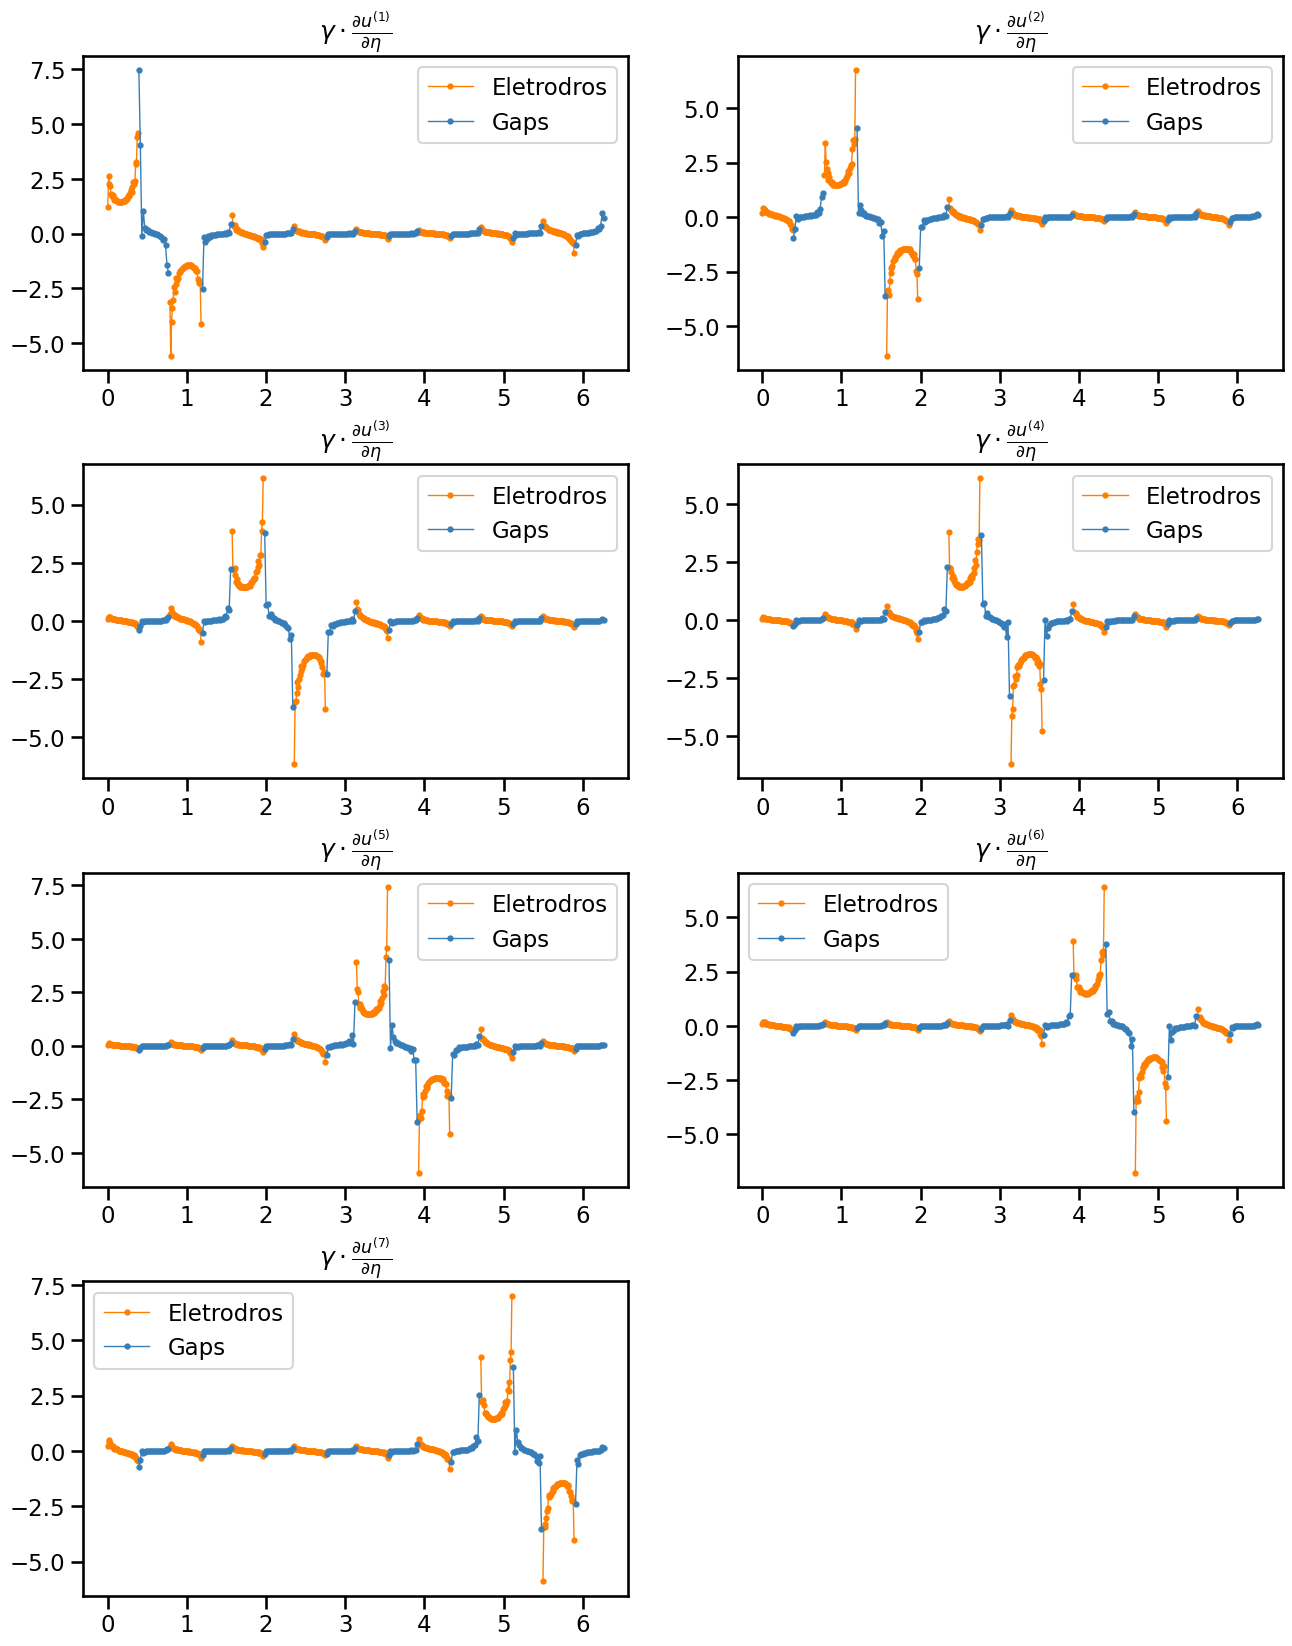

In [14]:
#Inputs
n = FacetNormal(mesh) #Normal vector
fig, ax = plt.subplots(4,2, figsize=(15,20), sharex=False) #Preparing Figure
#Loop
j=0
m=0
for i, u in enumerate(list_u):
    #Writing a variational problem to find \gamma grad(u)\cdot n at boundary
    Q=FunctionSpace(mesh, "CG", 1)
    p, q = TrialFunction(Q), TestFunction(Q)
    M = assemble(inner(p, q)*ds)

    L0 = inner(inner(n,gamma*grad(u)), q)*ds
    b = assemble(L0)

    #Minimizing a Tikhonov functional
    u_normal = Function(Q)
    u_normal_vec = u_normal.vector()
    I=np.identity(np.shape(M.array())[0])
    u_normal_vec[:] = np.linalg.solve(M.array().T@M.array()+1E-15*I,M.array().T@b[:])


    #Plotting information

    #Getting boundary data
    u_data =getBoundaryVertex(mesh, u_normal);
    data=plot_boundary(mesh, data=u_data, line=0, plot=False);

    #Extract nodes data
    nodes_pos=data.T[0]
    values = data.T[1]

    #Auxiliar indexes
    j=i//2
    i=i%2
    m+=1
    
    elec_nodes = []
    for elec_pos in mesh.electrodes.position:
        a,b= elec_pos[0], elec_pos[1]
        elec_nodes.append(np.where(np.logical_and(nodes_pos>=a, nodes_pos<=b))[0])

    gap_nodes = []
    for k in range(L):
        if k<L-1: a, b= mesh.electrodes.position[k][1], mesh.electrodes.position[k+1][0]
        else: a, b= mesh.electrodes.position[k][1], 2*np.pi
        gap_nodes.append(np.where(np.logical_and(nodes_pos>a, nodes_pos<b))[0])

    #Plot
    label_elec="Eletrodros"
    for index in elec_nodes:
        ax[j][i].plot(nodes_pos[index], values[index], color="#ff7f00", linewidth=1, marker=".", markersize="7", label=label_elec) 
        ax[j][i].title.set_text(r'$\gamma \cdot \frac{\partial u^{(' + str(m) + ')}}{\partial \eta}$')
        label_elec=""


    label_gap="Gaps"
    for index in gap_nodes:
        ax[j][i].plot(nodes_pos[index], values[index], color="#377eb8", linewidth=1, marker=".", markersize="7", label=label_gap)   
        label_gap=""  

    ax[j][i].legend()

    
plt.subplots_adjust(left=0.1,
                    hspace=0.30
                     )
ax[3,1].set_axis_off() #Remove extra axis
plt.savefig("figures/{}/teste2_fluxos_front.png".format(exp_name), bbox_inches='tight', transparent=True)

### Teste 4: ${U_j^\star}^{(i)}(x):= u^{(i)}|_{E_j}(x) + z_j \gamma \frac{\partial u^{(i)}}{\partial \eta}(x)$,

#### Case 1: ${U_1^\star}^{(1)}(x):= u^{(1)}|_{E_1}(x) + z_1 \gamma \frac{\partial u^{(1)}}{\partial \eta}(x)$,

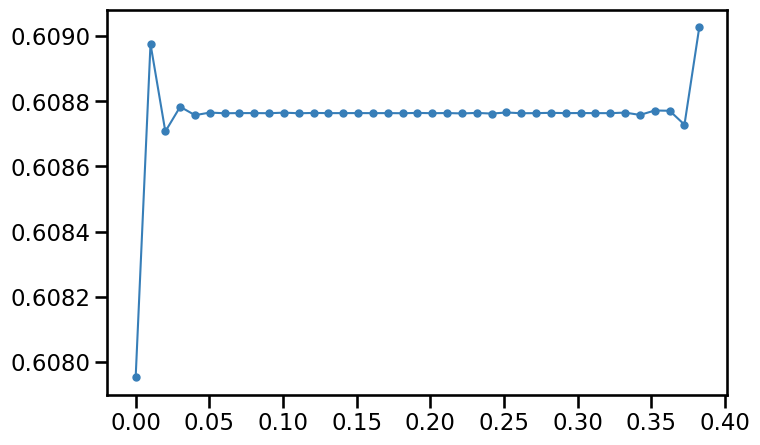

In [15]:
#Inputs
n = FacetNormal(mesh)
#fig, ax = plt.subplots(4,2, figsize=(15,12), sharex=True)
z=ForwardObject.z[0]
list_U_mean=[]
u=list_u[0]

#Writing a variational problem to find u+z\gamma grad(u)\cdot n at boundary
Q=FunctionSpace(mesh,"CG", 1)
p, q = TrialFunction(Q), TestFunction(Q)
M = assemble(inner(p, q)*ds)

L0 = inner(u+z*inner(n,gamma*grad(u)), q)*ds
b = assemble(L0)

#Minimizing a Tikhonov functional
u_normal = Function(Q)
u_normal_vec = u_normal.vector()
I=np.identity(np.shape(M.array())[0])
u_normal_vec[:] = np.linalg.solve(M.array().T@M.array()+1E-15*I,M.array().T@b[:])

u_data =getBoundaryVertex(mesh, u_normal);
data=plot_boundary(mesh, data=u_data, line=0, plot=False);

#Extract nodes data
nodes_pos=data.T[0]
values = data.T[1]

elec_nodes = []
for elec_pos in mesh.electrodes.position:
    a,b= elec_pos[0], elec_pos[1]
    elec_nodes.append(np.where(np.logical_and(nodes_pos>=a, nodes_pos<=b))[0])

elec1_index=elec_nodes[0]

plt.figure(figsize=(8,5))
plt.plot(nodes_pos[elec1_index], values[elec1_index], color="#377eb8", linewidth=1.5, marker=".", markersize="10", label=label_elec) 
plt.savefig("figures/{}/teste2_U1.png".format(exp_name), bbox_inches='tight', transparent=True)


#### Case 2: $\forall i \in \{1,\ldots,\ell\}$ and $\forall j \in \{1, \ldots, L\}$

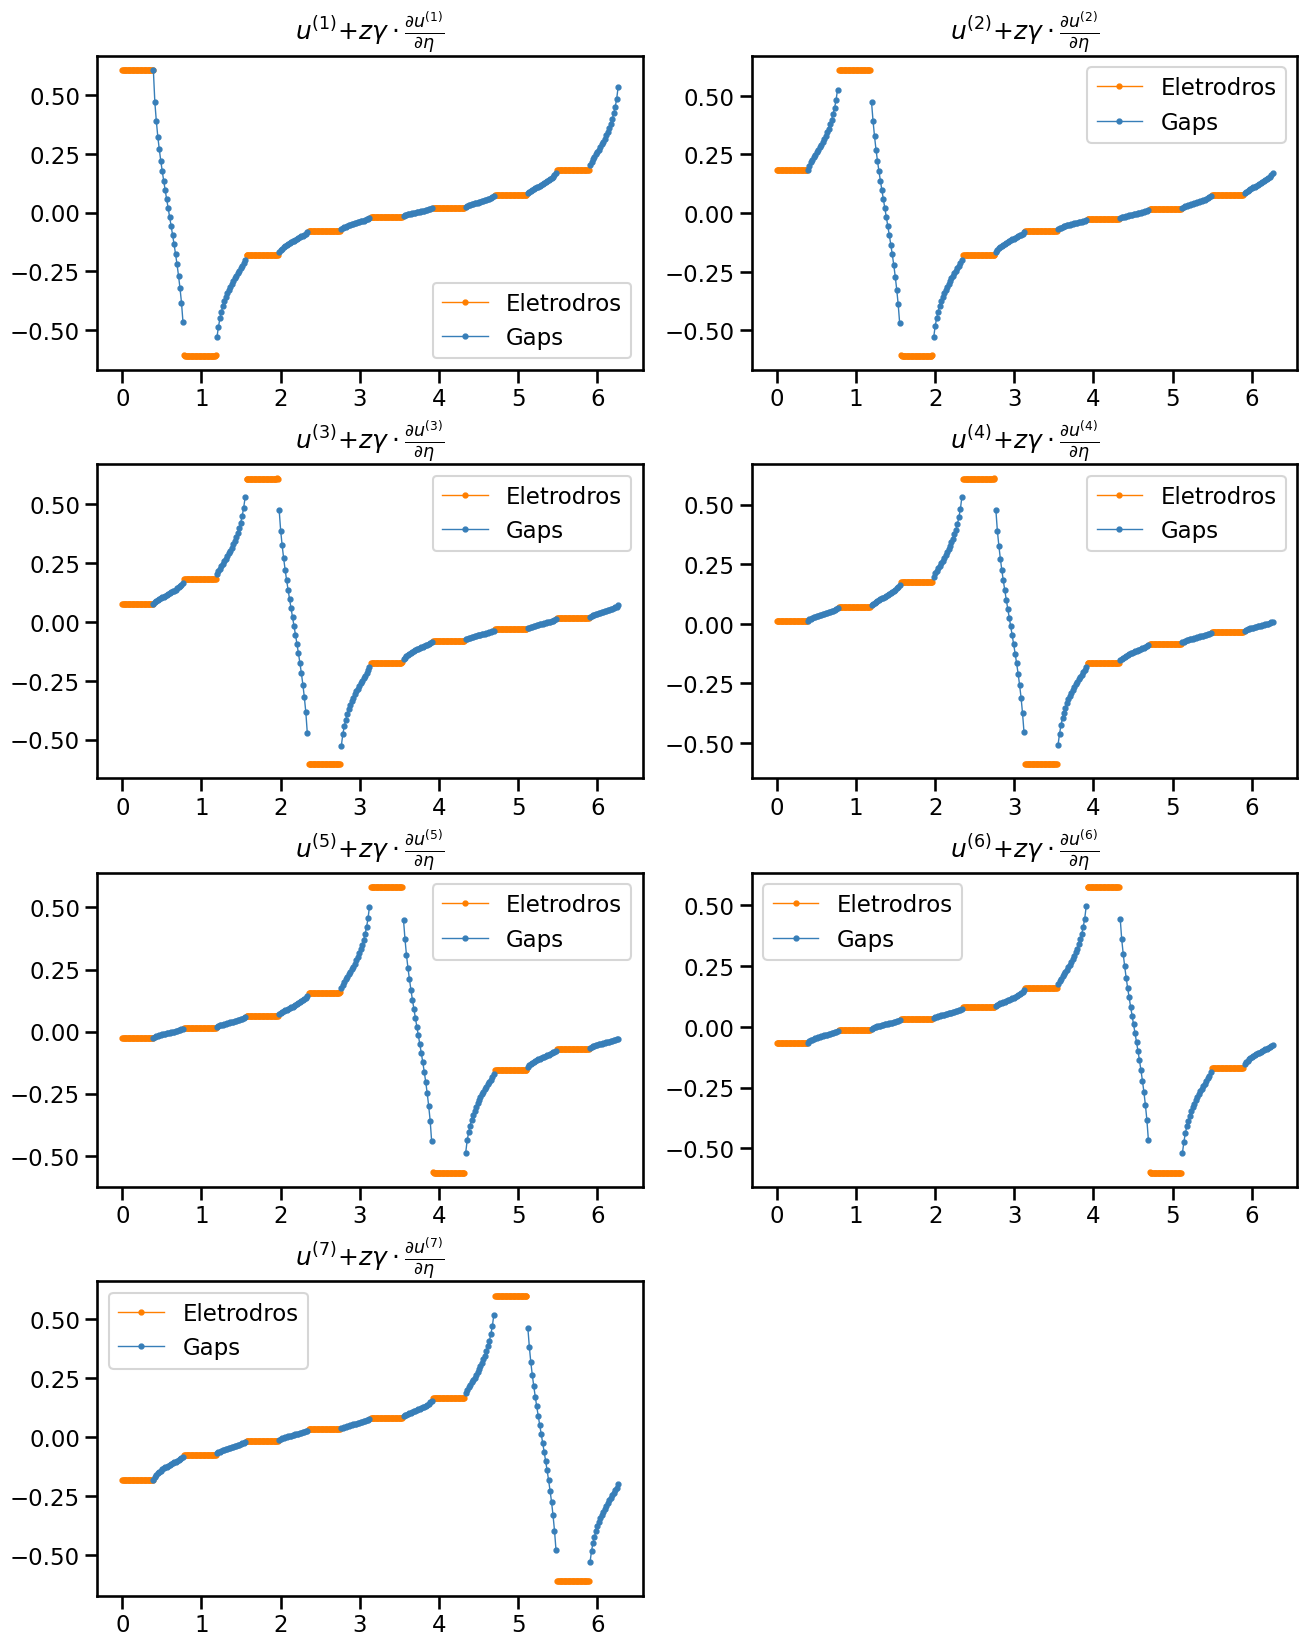

In [16]:
#Inputs
n = FacetNormal(mesh)
fig, ax = plt.subplots(4,2, figsize=(15,20), sharex=False)
z_0=ForwardObject.z[0]
list_U_mean=[]

#Loop
j=0
m=1
for i, u in enumerate(list_u):
    #Writing a variational problem to find u+z\gamma grad(u)\cdot n at boundary
    Q=FunctionSpace(mesh, "CG", 1)
    p, q = TrialFunction(Q), TestFunction(Q)
    M = assemble(inner(p, q)*ds)

    L0 = inner(u+z_0*inner(n,gamma*grad(u)), q)*ds
    b = assemble(L0)

    #Minimizing a Tikhonov functional
    u_normal = Function(Q)
    u_normal_vec = u_normal.vector()
    I=np.identity(np.shape(M.array())[0])
    u_normal_vec[:] = np.linalg.solve(M.array().T@M.array()+1E-15*I,M.array().T@b[:])


    #Plotting information
    #Auxiliar indexes
    j=i//2
    i=i%2

    u_data =getBoundaryVertex(mesh, u_normal);
    data=plot_boundary(mesh, data=u_data, line=0, plot=False);

    #Extract nodes data
    nodes_pos=data.T[0]
    values = data.T[1]


    elec_nodes = []
    for elec_pos in mesh.electrodes.position:
        a,b= elec_pos[0], elec_pos[1]
        elec_nodes.append(np.where(np.logical_and(nodes_pos>=a, nodes_pos<=b))[0])

    gap_nodes = []
    for k in range(L):
        if k<L-1: a, b= mesh.electrodes.position[k][1], mesh.electrodes.position[k+1][0]
        else: a, b= mesh.electrodes.position[k][1], 2*pi
        gap_nodes.append(np.where(np.logical_and(nodes_pos>a, nodes_pos<b))[0])

    #Estime potencial médio nos eletrodos
    U_vec_mean = []
    for index in elec_nodes:
        U_vec_mean.append(np.mean(values[index]))
    list_U_mean.append(np.array(U_vec_mean))
    
    #Plot
    label_elec="Eletrodros"
    for index in elec_nodes:
        ax[j][i].plot(nodes_pos[index], values[index], color="#ff7f00", linewidth=1, marker=".", markersize="7", label=label_elec) 
        ax[j][i].title.set_text(r'$u^{(' + str(m) + ')}}$' + 
                                r'$ + z \gamma \cdot \frac{\partial u^{(' + str(m) + ')}}{\partial \eta}$')
        label_elec=""

    label_gap="Gaps"
    for index in gap_nodes:
        ax[j][i].plot(nodes_pos[index], values[index], color="#377eb8", linewidth=1, marker=".", markersize="7", label=label_gap)   
        label_gap=""  

    ax[j][i].legend()
    m+=1
    
plt.subplots_adjust(left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    #wspace=0.4,
                    hspace=0.3)
ax[3,1].set_axis_off()
plt.savefig("figures/{}/teste2_U_partialOmega.png".format(exp_name), bbox_inches='tight', transparent=True)

#### $U-U^\star$

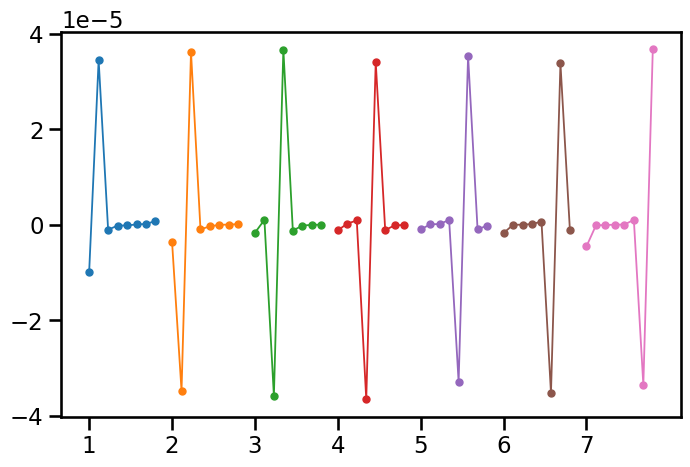

In [17]:
res_U0=(np.array(list_U_mean)-np.array(list_U0_m))

fig, ax = plt.subplots(figsize=(8,5))

for i, U_vec in enumerate(np.array(res_U0)):
    x=np.linspace(1,1.8,L)+i
    ax.plot(x,U_vec, linewidth=1.3, marker='.', markersize=10);

plt.xticks(np.arange(1,l+1,1))
plt.savefig("figures/{}/teste2_U_star.png".format(exp_name), bbox_inches='tight', transparent=True)


## Derivative Tests

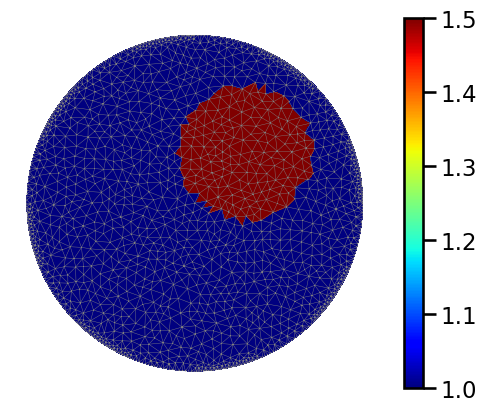

In [18]:
#GammaCircle returns a vector that is a map between elements and their cell values.
Q_DG = FunctionSpace(mesh, "DG", 0) #Define Function space with basis Descontinuous Galerkin
ValuesCells0=GammaCircle(mesh,1.5,1.0,0.4, 0.3, 0.3); #mesh, cond_in, cond_out, radius, certerx, cerntery
eta=Function(Q_DG)
eta.vector()[:]=ValuesCells0

"Plot"
plot_figure(eta, name="", map="jet");
plot(mesh, linewidth=0.3)
plt.xticks([])
plt.yticks([])
plt.box(False)
plt.savefig("figures/{}/teste2_eta.png".format(exp_name), bbox_inches='tight', transparent=True)

### Variational Method

### Calculating $\omega^{(i)}$

In [19]:
#Input
Intde=ForwardObject.ele_size #Electrode size
z=2.5E-5
#Spaces
V=FiniteElement('CG',mesh.ufl_cell(),1) #Solution Space Continous Galerkin
Rn=VectorElement("R", mesh.ufl_cell(), 0, dim=int(L)) #Vector in R_L for electrodes.
R=FiniteElement("R", mesh.ufl_cell(), 0)                   #Constant for Lang. Mult
W=FunctionSpace(mesh, MixedElement([V, Rn, R]))       #Defining Mixed space V x R_l x R

#Functions
u0=TrialFunction(W) #Functions that will be reconstructed.
v0=TestFunction(W)  #Test functions

omega, omega_n, omega_l = split(u0) #Project trial functions into subspaces
v, vn, vl = split(v0) #Project test functions into subspaces

#Lagrange Multiplier - Fixing grounding potential
lagrMult=0 
for i in range(0,L): lagrMult+=(vn[i]*omega_l+omega_n[i]*vl)*de(i+1) #Integral (v_i*u_mult+u_i*v_mult) d(electrode_i)

#Integral_\Omega \gamma <grad u, grad v) dx
a_inner = gamma*inner(grad(omega),grad(v))*dx

#Impedance part
a_imp=0
for i in range(L): a_imp+=1/z*(omega-omega_n[i])*(v-vn[i])*de(i+1)

#Variational formulation to matrix
A=assemble(a_inner+a_imp+lagrMult)

save_omega=[]
save_Omega=[]

#Define directional derivative
for h in range(l):
    I=I_all[h]
    #Right side variational equation
    b0=-eta*inner(grad(list_u[h]),grad(v))*dx
    b=assemble(b0)

    #Ax=b system
    w = Function(W) #Define a zero function based in W.
    U_vec = w.vector()  #Return a vector. (x=U)
    solve(A, U_vec, b)  #Solve system AU=b. where A matrix and b vector.

    #Project solutions
    omega_sol,Omega_sol, omega_lagr = w.split(True)
    save_omega.append(omega_sol)
    save_Omega.append(Omega_sol.vector()[:])
DevFdotEta_var=np.array(save_Omega).flatten()

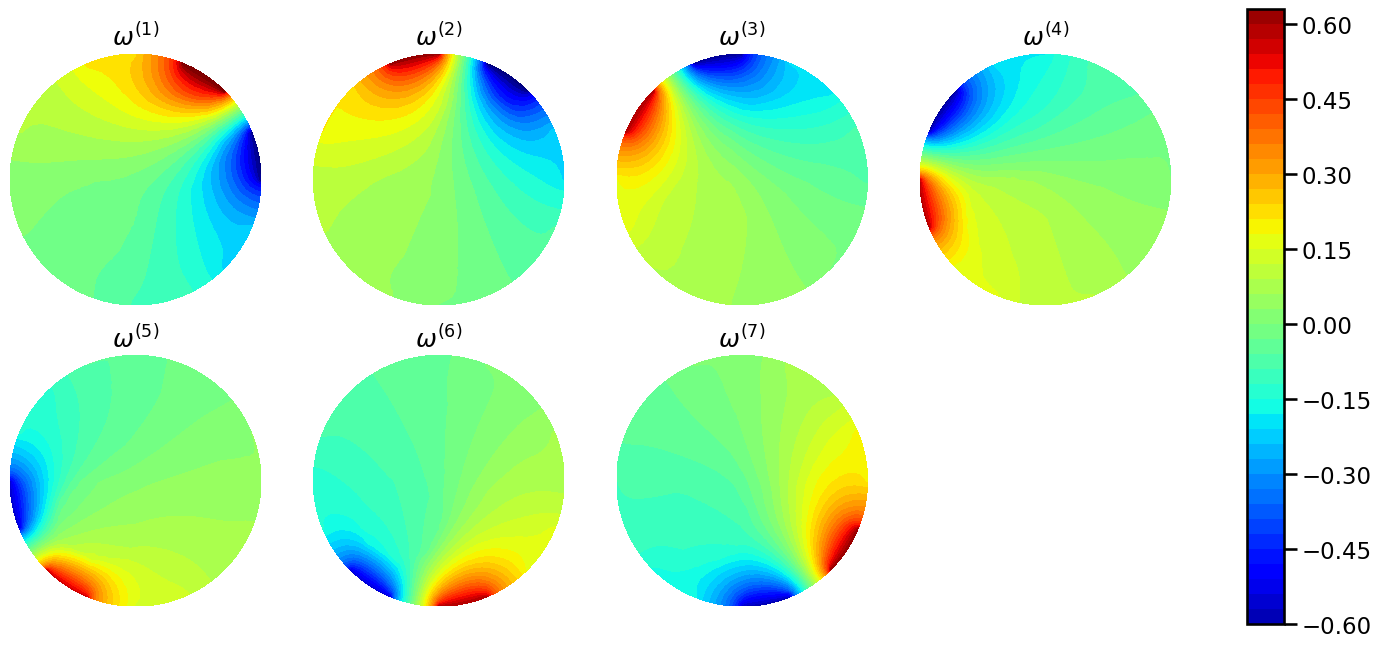

In [20]:
fig = plt.figure(figsize=(15,15))

for i,omega in enumerate(save_omega,1):
    plt.subplot(4,4,i)
    p = plot(omega, title=f'$\omega^{{({i})}}$')
    p.set_cmap("jet")
    p.set_clim(-0.65,0.65)
    plt.xticks([])
    plt.yticks([])
    plt.box(False)

cbar_ax = fig.add_axes([0.95,0.5,0.025,0.41])
fig.colorbar(p, cax=cbar_ax, orientation="vertical")
plt.savefig("figures/{}/teste2_omegas.png".format(exp_name), bbox_inches='tight', transparent=True)

### Graph $F^\prime(\gamma)\eta = \mathcal{W}$ Variational Method

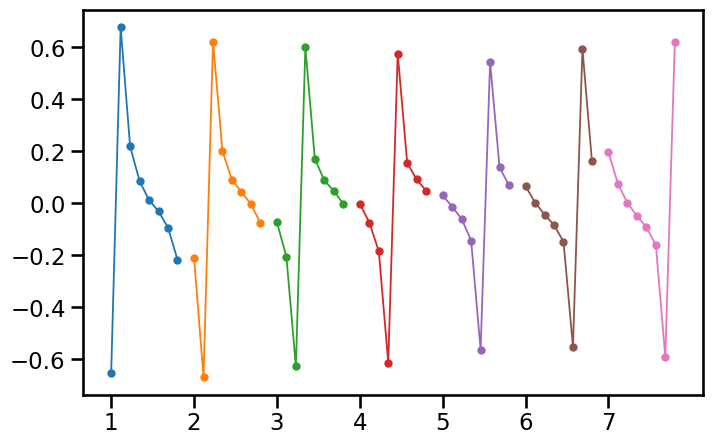

In [21]:
fig, ax = plt.subplots(figsize=(8,5))

for i, U_vec in enumerate(np.array(save_Omega)):
    x=np.linspace(1,1.8,L)+i
    ax.plot(x,U_vec, linewidth=1.3, marker='.', markersize=10);
plt.xticks(np.arange(1,l+1,1))

plt.savefig("figures/{}/teste2_W's.png".format(exp_name), bbox_inches='tight', transparent=True)

### Usual Method

In [22]:
#Input
Intde=ForwardObject.ele_size #Electrode size
z=2.5E-5
#Spaces
V=FiniteElement('CG',mesh.ufl_cell(),1) #Solution Space Continous Galerkin
Rn=VectorElement("R", mesh.ufl_cell(), 0, dim=int(L)) #Vector in R_L for electrodes.
R=FiniteElement("R", mesh.ufl_cell(), 0)                   #Constant for Lang. Mult
W=FunctionSpace(mesh, MixedElement([V, Rn, R]))       #Defining Mixed space V x R_l x R

#Functions
w0=TrialFunction(W) #Functions that will be reconstructed.
v0=TestFunction(W)  #Test functions

omega, omega_n, omega_l = split(w0) #Project trial functions into subspaces
v, vn, vl = split(v0) #Project test functions into subspaces

#Lagrange Multiplier - Fixing grounding potential
lagrMult=0 
for i in range(0,L): lagrMult+=(vn[i]*omega_l+omega_n[i]*vl)*de(i+1) #Integral (v_i*u_mult+u_i*v_mult) d(electrode_i)

#Integral_\Omega \sigma <grad u, grad v) dx
a_inner = gamma*inner(grad(omega),grad(v))*dx

#Impedance part
a_imp=0
for i in range(L): a_imp+=1/z*(omega-omega_n[i])*(v-vn[i])*de(i+1)

#Variational formulation to matrix
A=assemble((a_inner+a_imp+lagrMult))

save_omega=[]
DevF = []

#Define directional derivative
n_cells = mesh.num_cells()
Q_DG=FunctionSpace(mesh, "DG", 0)
eta_cell=Function(Q_DG)
#A = scipy.sparse.csc_matrix(A.array())
for cell in cells(mesh):
    if cell.index()%10==0:
        print(cell.index())
    
    eta_vec=np.zeros(n_cells)
    eta_vec[cell.index()]=1
    eta_cell.vector()[:]=eta_vec

    save_Omega=[]
    for h in range(l):
        I=I_all[h]
        #Right side variational equation
        b0=-eta_cell*inner(grad(list_u[h]),grad(v))*dx
        b=assemble(b0)

        #Ax=b system
        w = Function(W) #Define a zero function based in W.
        U_vec = w.vector()  #Return a vector. (x=U)
        solve(A, U_vec, b)  #Solve system AU=b. where A matrix and b vector.      
        #U_vec[:]=scipy.sparse.linalg.spsolve(A, b[:])
        #print(Omega_sol.vector()[:])

        #Project solutions
        omega_sol,Omega_sol, omega_lagr = w.split(True)
        save_omega.append(omega_sol)
        save_Omega.append(Omega_sol.vector()[:])
    DevFdotEta=np.array(save_Omega).flatten()
    DevF.append(DevFdotEta)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

### Graph $F^\prime(\gamma)\eta = \mathcal{W}$ Usual Method

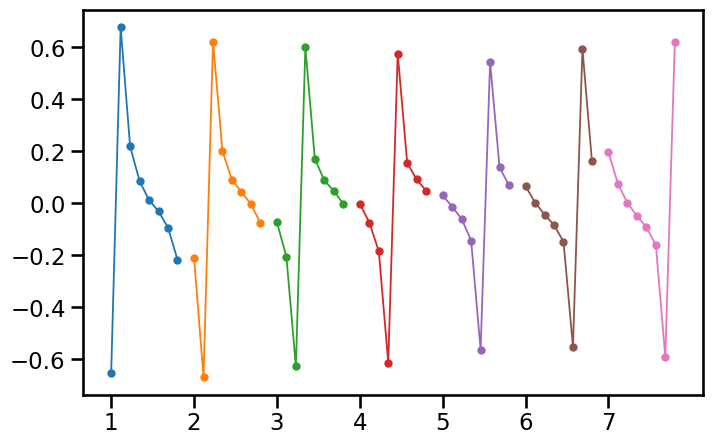

In [23]:
DevF2=np.array(DevF).T #Usual
Omega_vec = DevF2@eta.vector()[:]

Omega_m = np.reshape(Omega_vec, (l,L))
fig, ax = plt.subplots(figsize=(8,5))
for i, U_vec in enumerate(np.array(Omega_m)):
    x=np.linspace(1,1.8,L)+i
    ax.plot(x,U_vec, linewidth=1.3, marker='.', markersize=10);
plt.xticks(np.arange(1,l+1,1))
plt.savefig("figures/{}/teste2_W's_caro.png".format(exp_name), bbox_inches='tight', transparent=True)

### Polydorides' Method

In [24]:
#Preparing Jacobian at gamma
InverseObject=InverseProblem(mesh, list_U0, I_all, z*np.ones(L))
InverseObject.set_solverconfig(step_limit=0)
InverseObject.set_firstguess(gamma.vector()[:])
InverseObject.solve_inverse()
DevF_Polydorides = InverseObject.Jacobian_calc()

Residue (%)= 0.0  step: 0 Inner step:  0


### Graph $F^\prime(\gamma)\eta = \mathcal{W}$ Polydorides' Method

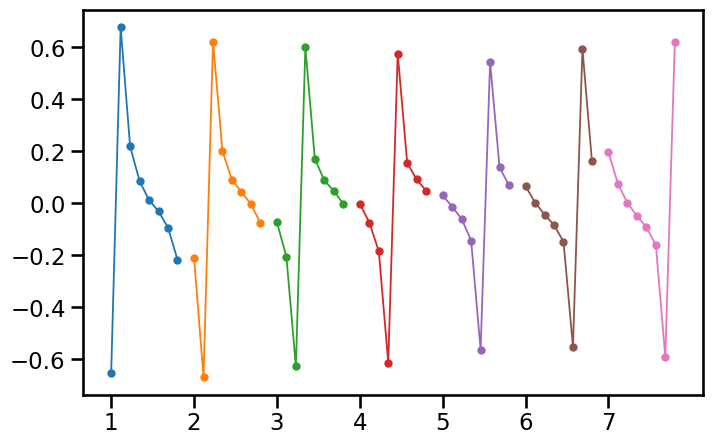

In [25]:
#Apply to direction eta
Omega_vec=DevF_Polydorides@eta.vector()[:]
Omega_m = np.reshape(Omega_vec, (l,L))

fig, ax = plt.subplots(figsize=(8,5))
for i, U_vec in enumerate(np.array(Omega_m)):
    x=np.linspace(1,1.8,L)+i
    ax.plot(x,U_vec, linewidth=1.3, marker='.', markersize=10);
plt.xticks(np.arange(1,l+1,1))
plt.savefig("figures/{}/teste2_W's_barato.png".format(exp_name), bbox_inches='tight', transparent=True)

### Graph Polydorides vs Usual

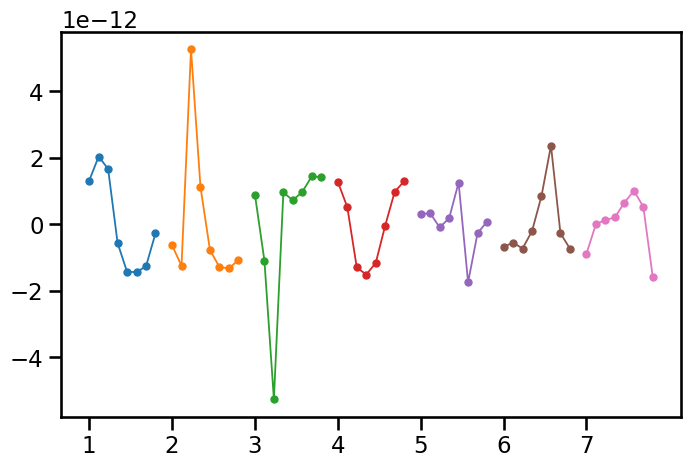

In [29]:
dif_Omega=DevF_Polydorides@eta.vector()[:]-DevF2@eta.vector()[:] #Polydorides vs Variacional
dif_Omega_m_PolyxVar = np.reshape(dif_Omega, (l,L))

fig, ax = plt.subplots(figsize=(8,5))
for i, U_vec in enumerate(np.array(dif_Omega_m_PolyxVar)):
    x=np.linspace(1,1.8,L)+i
    ax.plot(x,U_vec, linewidth=1.3, marker='.', markersize=10);
plt.xticks(np.arange(1,l+1,1))
plt.savefig("figures/{}/teste2_W's_Jac_dif.png".format(exp_name), bbox_inches='tight', transparent=True)

### Graph Usual vs Variational

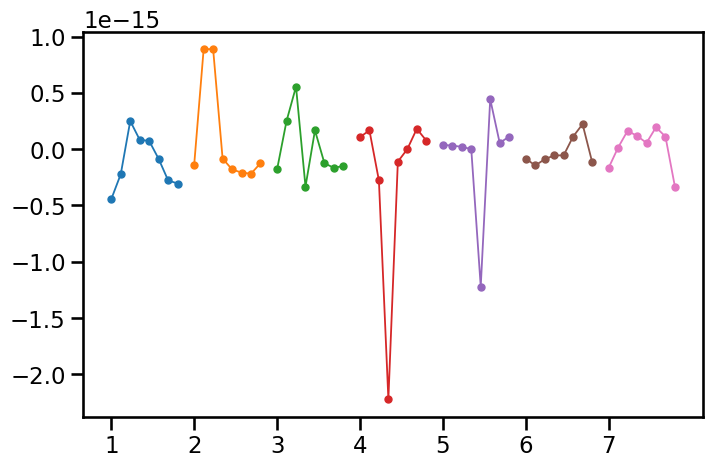

In [30]:
dif_Omega=DevF2@eta.vector()[:]-DevFdotEta_var #Polydorides vs Variacional
dif_Omega_m_CaroxVar = np.reshape(dif_Omega, (l,L))

fig, ax = plt.subplots(figsize=(8,5))
for i, U_vec in enumerate(np.array(dif_Omega_m_CaroxVar)):
    x=np.linspace(1,1.8,L)+i
    ax.plot(x,U_vec, linewidth=1.3, marker='.', markersize=10);
plt.xticks(np.arange(1,l+1,1))
plt.savefig("figures/{}/teste2_W's_ev_caro.png".format(exp_name), bbox_inches='tight', transparent=True)
plt.show()